# MODEL FOR PROPOSED ENFIELD BUILDING

In [1]:
import pandas as pd
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
class Person:
    """
    A class that represents a person at the food pantry.
    """
    # ATTRIBUTES:
    # Attribute order: the order the person visits the pressure points in the food pantry
    # Invariant: order is a list of Pressure_Points
    #
    # Attribute available: whether or not the person is available to go to the next station
    # Invariant: available is a boolean value
    #
    # Attribute enter: the time the person enters the food pantry
    # Invariant: enter is a positive int
    #
    # Attribute leave: the time the person leaves the food pantry
    # Invariant: leave is a positive int
    #
    # Attribute shopping_time: the total time spent shopping
    # Invariant: shopping_time is an int which is the sum of each Pressure_Point.time in self.order
    
    
    
    def __init__(self, model):
        """
        Initializes a Person object entering Model model.
        """
        self.order = model.pressure_points.copy()
        
        # Randomly chooses whether person goes to each station based on Pressure_Point.p
        i=0
        while i < len(self.order):
            if np.random.uniform() > self.order[i].p:
                self.order.pop(i)
            else:
                i += 1
#         random.shuffle(self.order)

        # forces "load car" to be the LAST station visited 
        copy = self.order[-1:]
        random.shuffle(copy)
        self.order[-1:] = copy
        
        # Set total time spent shopping
        self.shopping_time = 0
        
        # Set remaining attributes
        self.enter = model.iterations
        self.available = True
        self.leave = -1 #set this to -1 to indicate they haven't left yet
        
    def setLeave(self, iterations):
        """
        Sets the time the person leaves the food pantry.
        """
        self.leave = iterations
        
    def __str__(self):
        """
        Returns a string representing the person. i.e. the stations the person has to visit
        """
        str = "Stations remaining: "
        for i in self.order:
            str += ", " + i.name
        return str
    
class Car:
    """
    A class that represents a car at the food pantry parking lot.
    """
    # ATTRIBUTES:
    # Attribute parked: binary if car is parked or not
    # Invariant: parked is True or False 
    
    def __init__(self, model):
        """
        Initializes a Car object entering Model model.
        """
        self.parked = False;
        self.riders = []
        for i in range(model.per_car):
            #create per_car number of people to go in this car
            self.riders.append(Person(model))
            
    def getRidersDone(self):
        """
        Returns a boolean stating if all of the riders in this car have completed all of their tasks
        """
        riders_done = 0
        for i in self.riders:
            if (len(i.order)==0 and i.available):
                riders_done += 1
        if(riders_done == per_car):
            return True
        else: 
            return False
        
    def __str__(self):
        """
        Returns a string representing the person. i.e. the stations the person has to visit
        """
        str = "car"
        return str
        
        
    
class Pressure_Point:
    """
    A class that represents a pressure point in the food pantry.
    """
    # ATTRIBUTES:
    # Attribute name: the name of the pressure point
    # Invariant: name is a string
    #
    # Attribute capacity: the number of people that can shop at the pressure point at a time
    # Invariant: capacity is an int >= 0
    #
    # Attribute time: the time people spend at the pressure point
    # Invariant: time is an int >= 1
    #
    # Attribute atCapacity: whether or not the pressure point is full
    # Invariant: atCapacity is a boolean value
    #
    # Attribute people: the people shopping at the pressure point
    # Invariant: people is a list of People objects
    #
    # Attribute timeRemaining: the time each person in self.people has remaining at the pressure point
    # Invariant: timeRemaining is a list of ints >= 0 with the same length as self.people
    #
    # Attribute p: the probability a person shops at this pressure point
    # Invariant: p is an int or float between 0 and 1
    
    
    
    def __init__(self, name, capacity, time, p = 1):
        """
        Initializes a Pressure_Point object.
        """
        self.name = name
        self.capacity = capacity
        self.time = time
        self.atCapacity = False
        self.people = []
        self.timeRemaining = []
        self.p = p
        
        
    def update(self):
        """
        Updates attributes of the Pressure_Point after one minute has passed.
        """
        i = 0
        while i < len(self.timeRemaining):
            self.timeRemaining[i] -= 1
            if self.timeRemaining[i] < 0:
                self.timeRemaining.pop(i)
                self.people[i].available = True
                self.people.pop(i)
                self.atCapacity = False
            else:
                i += 1
            
    def add(self, person):
        """
        Attempts to add Person person to shop at this Pressure_Point.
        """
        # Checks if full
        if not self.atCapacity:
            person.available = False
            self.people.append(person)
            t = int(np.random.exponential(self.time))
            self.timeRemaining.append(t)
            person.shopping_time += t
            person.order.pop(0)
            if len(self.people) == self.capacity:
                self.atCapacity = True
    
    def __str__(self):
        """
        Returns a string representing this pressure point. 
        i.e. how much time each person at the pressure point has left to shop.
        """
        #return "Number of People: " + str(len(self.people))
        return "Time Remaining: " + str(self.timeRemaining)

class Model:
    """
    A class that represents a simulation model.
    """
    # ATTRIBUTES:
    # Attribute cars: the number of cars that arrive at the food pantry daily
    # Invariant: cars is an int or float >= 0
    #
    # Attribute per_car: the number of adults in each car
    # Invariant: per_car is an int > 0
    #
    # Attribute parking_lot: list of cars in the parking lot
    # Invariant: parking_lot is a list, make sure it does not exceed size parking_spots
    #
    # Attribute parking_spots: maxmimum number of cars that can park in lot at once
    # Invariant: parking_spots is an int >= 0
    #
    # Attribute parking_queue: a queue of cars that have arrived but cannot park
    # Invariant: parking_queue is an queue > 0
    #
    # Attribute hours_open: the number of hours open per day
    # Invariant: hours_open is an int or float >= 0
    #
    # Attribute arrival_rate: the number of cars that arrive at the food pantry per minute
    # Invariant: arrival_rate is an int or float >= 0
    #
    # Attribute pressure_points: the pressure_points in the food pantry
    # Invariant: pressure_points is a list of Pressure_Point objects
    #
    # Attribute iterations: how many minutes have been simulated in the model
    # Invariant: iterations is an int >= 0
    #
    # Attribute people: the people currently in the food pantry
    # Invariant: people is a list of People objects
    #
    # Attribute arrival_count: the amount of people that should have shown up since the last person
    # Invariant: arrival_count is an int or float >= 0
    #
    # Attribute people_arrived: the amount of people who arrived on the current day and entered the building
    # Invariant: people_arrived is an int >= 0
    #
    # Attribute people_arrived_car: the amount of people who arrived on the current day via car, may not have entered building
    # Invariant: people_arrived_car is an int >= 0
    #
    # Attribute cars_arrived: the amount of cars who arrived on the current day
    # Invariant: cars_arrived is an int >= 0
    #
    # Attribute parking_queue_length: the amount of cars in the parking queue
    # Invariant: parking_queue_length is an int >= 0
    #
    # Attribute day: the current day being simulated
    # Invariant: day is an int >= 0
    #
    # Attribute stats: the data collected from simulating
    # Invariant: stats is a list of pandas DataFrames
    #
    # Attribute arrival_stats: the amount of people who arrived on each day
    # Invariant: arrival_stats is a list of ints >= 0
    #
    # Attribute car_arrival_stats: the amount of cars that arrived on each day
    # Invariant: car_arrival_stats is a list of ints >= 0
    #
    # Attribute people_df: the people stats for the current day
    # Invariant: people_df is a pandas DataFrame
    #
    # Attribute flow_df: the flow stats for current day
    # Invariant: flow_df is a pandas DataFrame
    
    
    
    def setPressurePoints(self, names, times, capacities, ps):
        """
        Initializes self.pressure_points.
        """
        assert len(names) == len(times)
        assert len(names) == len(capacities)
        
        self.pressure_points = []
        
        for i in range(len(names)):
            self.pressure_points.append(Pressure_Point(names[i], capacities[i], times[i], ps[i]))
    
    
    def __init__(self, cars, per_car, parking_spots, hours_open, names, times, capacities, ps):
        """
        Initializes an instance of a model.
        """
        self.cars = cars
        self.per_car = per_car
        self.parking_spots = parking_spots
        self.parking_lot = [] #added parking lot list, manually need to make sure it doesn't go over parking_spots
        self.parking_queue = deque() #added empty queue for parking
        self.arrival_rate = cars / (hours_open * 60)
        self.hours_open = hours_open
        self.setPressurePoints(names, times, capacities, ps)
        self.iterations = 0
        self.people = []
        self.arrival_count = 0
        self.people_arrived = 0
        self.cars_arrived = 0
        self.parking_queue_length = 0
        self.people_arrived_car = 0 #added to count total number of ppl who arrived, but may not have gotten into building
        self.day = 0
        self.stats = []
        self.arrival_stats = []
        self.people_df = pd.DataFrame(columns = ['day', 'enter', 'leave', 'total_time', 'shopping_time', 'waiting_time'])
        self.flow_df = pd.DataFrame(columns = ['day', 'minute', 'number_of_people', 'parking lot', 'parking queue'])
        
        
    def iterate(self):
        """
        Performs the actions of one minute in the food pantry.
        """
        self.iterations += 1
        # self.arrival_count += self.arrival_rate # use this for if arrival rate is constant
        self.arrival_count += np.random.poisson(self.arrival_rate) # use this for is arrival rate is poisson
        
        # uncomment below to use a right-skewed arrival rate with 20% of cars arriving at minute 1 (visualization 2)
#         if(self.iterations==1 or self.iterations % (self.hours_open*60) == 1): # iteration 1 or 181, etc.
#             self.arrival_count += int(0.25*self.cars)
#         else:
#             self.arrival_count += np.random.poisson((self.cars - int(0.25*self.cars)) / (self.hours_open * 60)) #poisson for remaining 
        
#         print('iteration:', self.iterations, 'people arrived:', self.arrival_count)
        
        # Simulate cars arriving
        while self.arrival_count >= 1:
            # add car to parking queue
            current_car = Car(self)
            self.parking_queue.append(current_car)
            self.cars_arrived += 1
            self.arrival_count -= 1
            for rider in current_car.riders:
                self.people_arrived_car += 1
#             print('car was added to queue')
            
            
        # If there are open parking spots, let people in queue park
        while len(self.parking_lot)<self.parking_spots and len(self.parking_queue)>0:
            queue_car = self.parking_queue.popleft()
            self.parking_lot.append(queue_car)
            for rider in queue_car.riders:
                self.people.append(rider) #add rider to people lsit
                self.people_arrived += 1 # increase number of people at the store 
#             print('car was able to park')
        self.parking_queue_length += len(self.parking_queue)
        
        # Update each Pressure_Point
        for i in self.pressure_points:
            i.update()
        
        # Simulate people leaving and shopping at each Pressure_Point and collect data
        i = 0
        while i < len(self.people):
            if len(self.people[i].order) == 0 and self.people[i].available:
                self.people[i].setLeave(self.iterations)
                self.people_df.loc[len(self.people_df.index)] = [self.day, self.people[i].enter - (60 * self.hours_open * (self.day - 1)), 
                                                                 self.people[i].leave - (60 * self.hours_open * (self.day - 1)), 
                                                           self.people[i].leave - self.people[i].enter,
                                                           self.people[i].shopping_time, 
                                                           self.people[i].leave - self.people[i].enter - self.people[i].shopping_time]
                self.people.pop(i) 
            else:
                if self.people[i].available:
                    self.people[i].order[0].add(self.people[i])
                i += 1
        for cars in self.parking_lot:
            if(cars.getRidersDone()):
                self.parking_lot.remove(cars)
#                 print('CAR HAS BEEN REMOVED')
        
        self.flow_df.loc[len(self.flow_df.index)] = [self.day, self.iterations - (60 * self.hours_open * (self.day - 1)), len(self.people), len(self.parking_lot), len(self.parking_queue)]
        # Print the state of the model
#         self.print_state()
                
            
    def simulate_day(self):
        """
        Runs simulation for one day.
        """
        self.day += 1
        i = 0
        self.arrival_count = 0
        self.people_arrived = 0
        self.people_arrived_car = 0
        self.cars_arrived = 0
        self.parking_queue_length = 0
        self.parking_lot = []
        self.parking_queue = deque()
        self.people = []
        self.people_df = pd.DataFrame(columns = ['day', 'enter', 'leave', 'total_time', 'shopping_time', 'waiting_time'])
        self.flow_df = pd.DataFrame(columns = ['day', 'minute', 'number_of_people', 'parking lot', 'parking queue'])
        while i < self.hours_open * 60:
            i += 1
            self.iterate()
        self.stats.append([self.people_df, self.flow_df])
        self.arrival_stats.append([self.people_arrived,
                                   self.people_arrived_car,
                                   self.cars_arrived,
                                   self.parking_queue_length/(self.hours_open * 60)])
        
        
    def print_state(self):
        """
        Prints the current state of the model.
        """
        print('TIME: ', self.iterations)
        print("PARKING LOT:", len(self.parking_lot))
#         for i in self.parking_lot:
#             print(str(i))
        print("PARKING QUEUE:", len(self.parking_queue))
#         for i in self.parking_queue:
#             print(str(i))
        print("PEOPLE:")
        for i in self.people:
            print(str(i))
        print("PRESSURE POINTS:")
        for i in self.pressure_points:
            print(str(i))
        print("--------")
                
                
    def simulate(self, days):
        """
        Runs the simulation for days days.
        """
        for i in range(days):
            self.simulate_day()

In [4]:
# Initialize the model with given data from Enfield
cars = 100
per_car = 2
parking_spots = 20
hours_open = 3
names = ["rescued produce", "assorted meats", "baked goods", "clothes", "load car"]
times = [5, 5, 5, 10, 4]
capacities = [3, 3, 3, 7, 1000] # capacity for loading car should be infinite since (assume less than 1000 shoppers at a time)
ps = [1, 1, 1, .25, 1]
enfield = Model(cars, per_car, parking_spots, hours_open, names, times, capacities, ps)

In [34]:
# Run the simulation for 14 days
enfield.simulate(1)

In [35]:
# Collect aggregate data in one DataFrame
df = pd.DataFrame(columns = ['day',
                             'shoppers_served',
                             'shoppers_arrived',
                             'people_arrived',
                             'cars_arrived',
                             'avg_parking_queue',
                             'avg_total_time',
                             'avg_shopping_time',
                             'avg_waiting_time'])

for i in range(len(enfield.stats)):
    df.loc[i] = [int(enfield.stats[i][0]['day'][0]),
                             len(enfield.stats[i][0].index),
                             enfield.arrival_stats[i][0],
                             enfield.arrival_stats[i][1],
                             enfield.arrival_stats[i][2],
                             enfield.arrival_stats[i][3],
                             enfield.stats[i][0]['total_time'].mean(),
                             enfield.stats[i][0]['shopping_time'].mean(),
                             enfield.stats[i][0]['waiting_time'].mean()]
df

,day,shoppers_served,shoppers_arrived,people_arrived,cars_arrived,avg_parking_queue,avg_total_time,avg_shopping_time,avg_waiting_time
0,1.0,76.0,112.0,190.0,95.0,10.472222,52.723684,18.618421,34.105263


In [36]:
enfield.stats[0][0].head()

,day,enter,leave,total_time,shopping_time,waiting_time
0,1,4,9,5,1,4
1,1,4,17,13,9,4
2,1,5,17,12,8,4
3,1,6,25,19,9,10
4,1,5,26,21,16,5


In [37]:
enfield.stats[0][1].head()

,day,minute,number_of_people,parking lot,parking queue
0,1,1,0,0,0
1,1,2,0,0,0
2,1,3,0,0,0
3,1,4,2,1,0
4,1,5,4,2,0


# function to plot shoppers in store for 1 day

In [38]:
def shoppers_in_store(enfield):
    """
    who_is_in_store_d1 = pd.DataFrame(columns=["time", 'number_of_shoppers'])
    for j in range(enfield.hours_open*60): #adds shoppers in store based on their arrival and leaving times... but only people that COMPLETED their trip
        in_store_count = 0
        for i in range(len(daily_df_day1)):
            if(daily_df_day1.loc[i]['enter']<=j and daily_df_day1.loc[i]['leave']>j):
                in_store_count = in_store_count+1
        who_is_in_store_d1.loc[j] = [j, in_store_count]
    not_counted = [] #list of when shoppers who didn't finish ARRIVED
    for i in enfield.people:
        not_counted.append(i.enter)
    for n in not_counted:
        for j in range(n, enfield.hours_open*60):
            who_is_in_store_d1.loc[j]['number_of_shoppers'] = who_is_in_store_d1.loc[j]['number_of_shoppers'] + 1
    who_is_in_store_d1.plot(y='number_of_shoppers', use_index=True)
    """
    plt.plot(enfield.stats[0][1]['number_of_people'])
    plt.title('Number of shoppers in a day with ' + str(enfield.cars) +' cars and ' + str(enfield.parking_spots) +' parking spots')
    plt.xlabel("Time (minutes)")
    plt.ylabel("Number of shoppers inside building")

    plt.show()

# function to plot parking lot and queue for 1 day

In [39]:
import seaborn as sns

def parking_plot(model):
    x = model.stats[0][1]['minute']
    y0 = model.stats[0][1]['parking lot']
    y1 = model.stats[0][1]['parking queue']

    plt.plot(x, y0, 'r')
    plt.plot(x, y1, 'b') 
    plt.legend(['parking lot', 'parking queue'])
    plt.xlabel("Time (minutes)")
    plt.ylabel("Number of cars")
    plt.title("Number of cars in lot and queue with " + str(model.cars) + " cars and " + str(model.parking_spots) + " parking spots")
    
    plt.show()
    

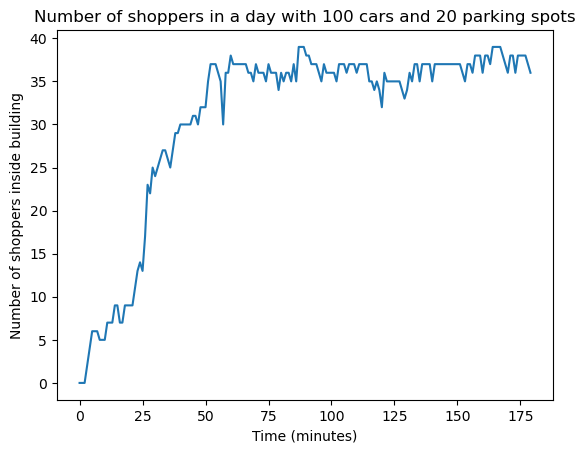

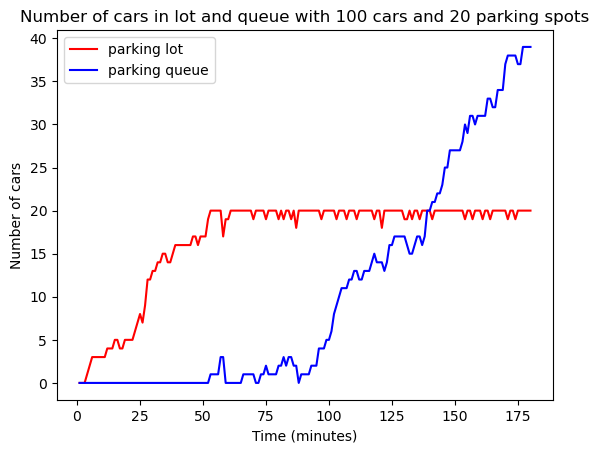

In [40]:
shoppers_in_store(enfield)
parking_plot(enfield)

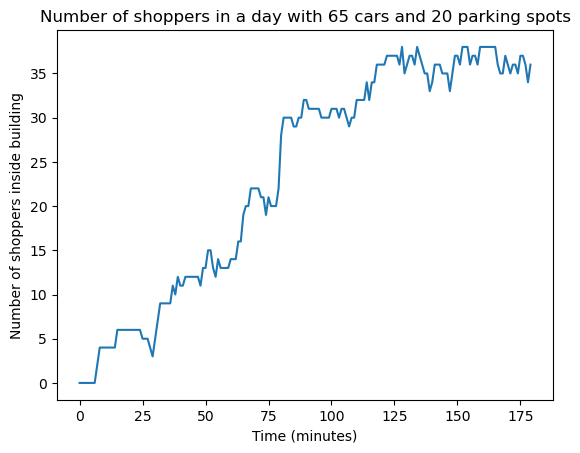

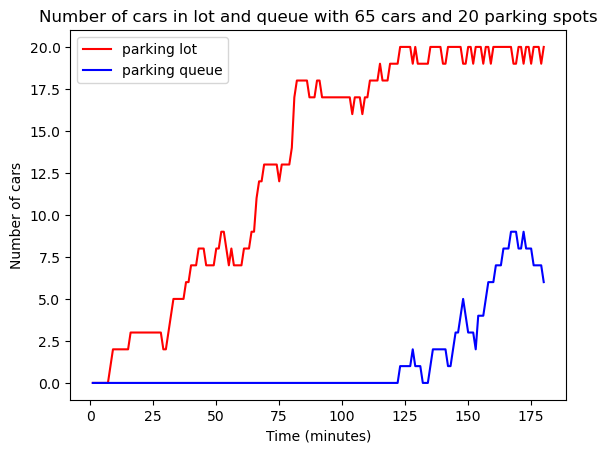

In [41]:
#change model attributes slightly
new_cars = 65
enfield_65 = Model(new_cars, per_car, parking_spots, hours_open, names, times, capacities, ps)
enfield_65.simulate(1)
shoppers_in_store(enfield_65)
parking_plot(enfield_65)

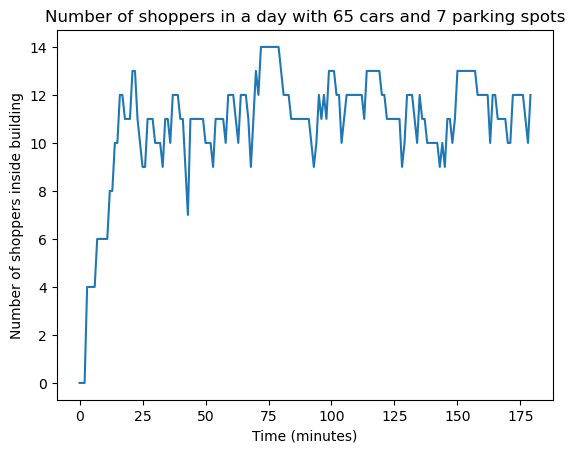

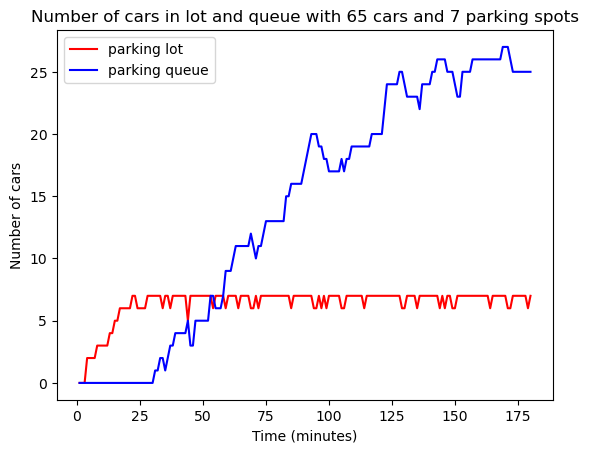

In [42]:
new_parking_spots = 7
enfield_65_7 = Model(new_cars, per_car, new_parking_spots, hours_open, names, times, capacities, ps)
enfield_65_7.simulate(1)
shoppers_in_store(enfield_65_7)
parking_plot(enfield_65_7)

# Final Report Visualizations:

### Visualization 1 (Jack)

In [157]:
# Initialize the model with given data from Enfield
cars = 65
per_car = 2
parking_spots = 20
hours_open = 3
names = ["rescued produce", "assorted meats", "baked goods", "clothes", "load car"]
times = [5, 5, 5, 10, 4]
capacities = [3, 3, 3, 7, 1000] # capacity for loading car should be infinite since (assume less than 1000 shoppers at a time)
ps = [1, 1, 1, .25, 1]
enfield = Model(cars, per_car, parking_spots, hours_open, names, times, capacities, ps)

This model uses parameters based on the number of available parking spots of the proposed new building and the arrival rate, station capacities, and estimated shopping times of the current building. Cars arrive to the parking lot at a rate determined by a poisson distribution with $\lambda = 65/(3*60) = 0.361)$. Each car contains two passengers. The shopping times are determined by an exponential distribution with $\frac{1}{\lambda} = 5$ which is the expected number of minutes it takes to shop at each station. This visualization can be seen as the control with standard arrival rate and parking spots.

In [158]:
enfield.simulate(14)

In [159]:
enfield.stats[0][0].head()

,day,enter,leave,total_time,shopping_time,waiting_time
0,1,1,11,10,6,4
1,1,1,11,10,6,4
2,1,4,18,14,9,5
3,1,7,21,14,8,6
4,1,4,26,22,17,5


In [169]:
enfield.stats[0][1]

,day,minute,number_of_people,parking lot,parking queue
0,1,1,2,1,0
1,1,2,2,1,0
2,1,3,2,1,0
3,1,4,4,2,0
4,1,5,4,2,0
...,...,...,...,...,...
175,1,176,39,20,1
176,1,177,37,20,1
177,1,178,36,19,1
178,1,179,38,20,1


In [161]:
def avg_stats(model):
    avg_people_df = pd.DataFrame(columns = ['days',
                             'avg_shoppers_served',
                             'avg_shoppers_arrived',
                             'avg_people_arrived',
                             'avg_cars_arrived',
                             'avg_parking_queue',
                             'avg_total_time',
                             'avg_shopping_time',
                             'avg_waiting_time'])
    people_dfs = model.stats[0][0]
    for i in model.stats[1:]:
        people_dfs = pd.concat([people_dfs, i[0]])
    stats = np.array(model.arrival_stats)                         
    avg_people_df.loc[0] = [len(model.stats),
                            len(people_dfs.index)/len(model.stats),
                            stats[:, 0].mean(),
                            stats[:, 1].mean(),
                            stats[:, 2].mean(),
                            stats[:, 3].mean(),
                            people_dfs['total_time'].mean(),
                            people_dfs['shopping_time'].mean(),
                            people_dfs['waiting_time'].mean()]
    
    flow_dfs = model.stats[0][1].set_index('minute')
    for i in model.stats[1:]:
        flow_dfs = pd.concat([flow_dfs, i[1]])
    avg_flow_dfs = flow_dfs.groupby('minute').sum()[['number_of_people', 'parking lot', 'parking queue']]/len(model.stats)
    return round(avg_people_df, 2), round(avg_flow_dfs, 2)
avg_stats(enfield)[0]

,days,avg_shoppers_served,avg_shoppers_arrived,avg_people_arrived,avg_cars_arrived,avg_parking_queue,avg_total_time,avg_shopping_time,avg_waiting_time
0,14.0,73.71,110.0,136.43,68.21,4.29,55.45,18.68,36.77


Text(0.5, 1.0, 'Number of People In the Store Throughout the Day')

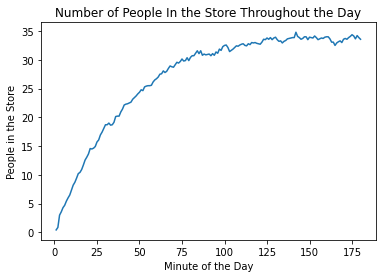

In [162]:
plt.plot(avg_stats(enfield)[1]['number_of_people'])
plt.ylabel('People in the Store')
plt.xlabel('Minute of the Day')
plt.title('Number of People In the Store Throughout the Day')

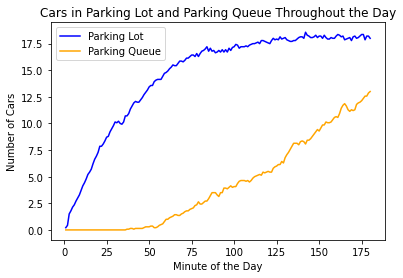

In [163]:
plt.plot(avg_stats(enfield)[1]['parking lot'], color = 'blue', label = 'Parking Lot')
plt.plot(avg_stats(enfield)[1]['parking queue'], color = 'orange', label = 'Parking Queue')
plt.ylabel('Number of Cars')
plt.xlabel('Minute of the Day')
plt.title('Cars in Parking Lot and Parking Queue Throughout the Day')
plt.legend()

These visualizations show the average number of people in the food pantry, cars in the parking lot, and in the parking queue at each minute of the day based on aggregated data of 14 days of simulation. From these visualizations, we can see that the maximum number of people in the food pantry at one time is about 35 people with these parameters, and the number of people grows logarithmically throughout the day.  Similarly, the number of cars in the parking lot grows logarithmically throughout the day. The parking lot has a capacity of 20 cars which it approaches around the middle of the day based on the visualization. The number of cars in the parking queue appears to grow exponentially once the parking lot reaches its maximum capacity, leading us to the conclusion that cars are arriving a lot quicker than people are able to shop in the store.

### Visualization 2 (Mary)

This model uses the same parameters as Visualization 1, but the arrival rate within the simulation varies. Instead of a poisson arrival rate with $\lambda = cars$, this simulation has an arrival rate such that 25% of the total cars (16) arrive at minute 1 of the simulation, and the expected remaining cars (49) arrival with a poisson distribution ($\lambda = (49)/(3*60) = 0.272$ cars per minute). This is compared to the poisson distribution used in Visualization 1 of $\lambda = 65/(3*60) = 0.361)$.

In [226]:
# Initialize the model with given data from Enfield
cars = 65
per_car = 2
parking_spots = 20
hours_open = 3
names = ["rescued produce", "assorted meats", "baked goods", "clothes", "load car"]
times = [5, 5, 5, 10, 4]
capacities = [3, 3, 3, 7, 1000] # capacity for loading car should be infinite since (assume less than 1000 shoppers at a time)
ps = [1, 1, 1, .25, 1]
enfield2 = Model(cars, per_car, parking_spots, hours_open, names, times, capacities, ps)

In [227]:
enfield2 = Model(cars, per_car, parking_spots, hours_open, names, times, capacities, ps)
enfield2.simulate(14)

In [228]:
# this function is adapted from visualization 1
def avg_stats2(model):
    avg_people_df = pd.DataFrame(columns = ['days',
                             'avg_shoppers_served',
                             'avg_shoppers_arrived',
                             'avg_people_arrived',
                             'avg_cars_arrived',
                             'avg_parking_queue',
                             'avg_total_time',
                             'avg_shopping_time',
                             'avg_waiting_time'])
    people_dfs = model.stats[0][0]
    for i in model.stats[1:]:
        people_dfs = pd.concat([people_dfs, i[0]])
    stats = np.array(model.arrival_stats)  
#     print(stats)
    avg_people_df.loc[0] = [len(model.stats),
                            len(people_dfs.index)/len(model.stats),
                            stats[:, 0].mean(),
                            stats[:, 1].mean(),
                            stats[:, 2].mean(),
                            stats[:, 3].mean(),
                            people_dfs['total_time'].mean(),
                            people_dfs['shopping_time'].mean(),
                            people_dfs['waiting_time'].mean()]
    
    flow_dfs = model.stats[0][1].set_index('minute')
    for i in model.stats[1:]:
        i[1] = i[1].set_index('minute') # changed because visualization 1 function didn't work for aggregating this data
                                        # thus you can only run this function once due to this set_index
        flow_dfs = pd.concat([flow_dfs, i[1]])
    avg_flow_dfs = flow_dfs.groupby('minute').sum()[['number_of_people', 'parking lot', 'parking queue']]/len(model.stats)
    return round(avg_people_df, 2), round(avg_flow_dfs, 2)

In [229]:
visualization2_stats0, visualization2_stats1  = avg_stats2(enfield2)

As expected, the number of people at minute 1 in every iteration is the same: 25% of 65 total cars, or 16 cars, arrive at minute 1, resulting in exactly $2*16=32$ people in the store. This is less than the total number of parking spots, so no one is forced to wait in the queue. This arrival rate on average serves more shoppers per day but has a slightly higher average parking queue, and an over 20-minute increase in total time spent in the store due to higher average waiting times. 

In [230]:
visualization2_stats0

,days,avg_shoppers_served,avg_shoppers_arrived,avg_people_arrived,avg_cars_arrived,avg_parking_queue,avg_total_time,avg_shopping_time,avg_waiting_time
0,14.0,76.71,111.14,124.14,62.07,4.92,77.61,18.17,59.44


In [231]:
visualization2_stats1.head()

,number_of_people,parking lot,parking queue
minute,,,
1,32.00,16.00,0.0
2,32.86,16.43,0.0
3,33.57,16.79,0.0
4,33.86,16.93,0.0
5,34.14,17.07,0.0


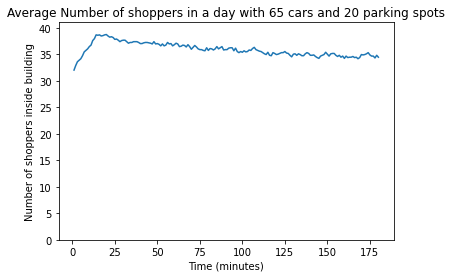

In [232]:
plt.plot(visualization2_stats1['number_of_people'])

plt.title('Average Number of shoppers in a day with ' + str(enfield2.cars) +' cars and ' + str(enfield2.parking_spots) +' parking spots')
plt.xlabel("Time (minutes)")
plt.ylabel("Number of shoppers inside building")
plt.ylim([0, 41])
plt.show()

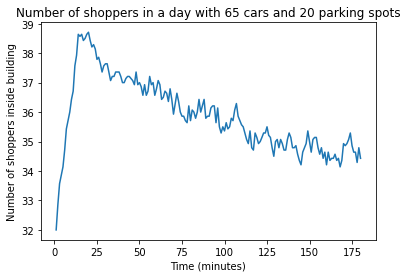

In [233]:
plt.plot(visualization2_stats1['number_of_people'])

plt.title('Number of shoppers in a day with ' + str(enfield2.cars) +' cars and ' + str(enfield2.parking_spots) +' parking spots')
plt.xlabel("Time (minutes)")
plt.ylabel("Number of shoppers inside building")
plt.show()

On average, according to the plot above, the number of shoppers generally seems to decrease throughout the day. This is because a large portion of the shoppers instantly arrive and begin shopping at the beginning of the simulation, and then the remaining 49 cars are used to create a poisson arrival rate with $\lambda=0.272$ (49 cars for the rest of the day total) instead of $\lambda = 0.361$ (65 cars total). This arrival rate is likely less than the general output rate of the servers of the food pantry, resulting in a general decrease throughout the day. 

Text(0.5, 1.0, 'Number of cars in lot and queue with 65 cars and 20 parking spots')

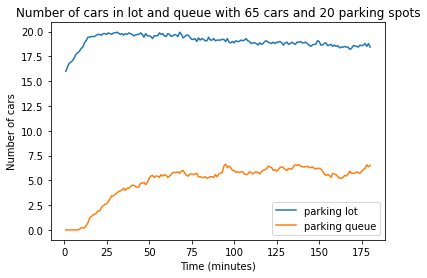

In [234]:
plt.plot(visualization2_stats1['parking lot'])
plt.plot(visualization2_stats1['parking queue'])

plt.legend(['parking lot', 'parking queue'])
plt.xlabel("Time (minutes)")
plt.ylabel("Number of cars")
plt.title("Number of cars in lot and queue with " + str(enfield2.cars) + " cars and " + str(enfield2.parking_spots) + " parking spots")

The parking lot initially starts with 16 cars and no one forced into the parking queue. However, since the parking lot has 20 spots, very quickly it fills and requires some cars to wait in the queue. The arrival rate/distribution for the rest of the cars after minute 1 is much lower than at the beginning, so cars arrive sparcely, but often arrive when the parking lot is full, thus having to wait in the queue. 

Although a lot of cars arrive at the beginning of the simulation, the capacities of the servers inside the food pantry do not allow all the shoppers to actively begin their tasks, so the processing rate reaches its limit. This means there isn't a time where suddenly all 16 of the original cars leave around the same time... instead these shoppers are standing around waiting for an open server and won't leave the pantry until others are finished and able to clear out.

### Visualization 3 (Jasmine)
This visualization simulates if there is not a queue for the parking lot but due to longer time spent in the store , there is potential for a bottleneck in the parking lot. We will similarly explore a scenario where the parking spots available is 20. For shopping times, they were originally determinted by an expotnential distribution 1/λ, the expected number of minutes it takes to shop at each station. In this variation, the times have been doubled for all stations other than loading the car. We will observe how this effects both the waiting time as well as the average parking queue.

In [73]:
cars = 65
per_car = 2
parking_spots = 20
hours_open = 3
names = ["rescued produce", "assorted meats", "baked goods", "clothes", "load car"]
times = [10, 10, 10, 20, 4]
capacities = [3, 3, 3, 7, 1000]
enfield_new = Model(cars, per_car, parking_spots, hours_open, names, times, capacities, ps)

In [74]:
enfield_new.simulate(14)
enfield_new.stats[0][0].head()

,day,enter,leave,total_time,shopping_time,waiting_time
0,1,33,56,23,17,6
1,1,33,59,26,22,4
2,1,33,60,27,8,19
3,1,33,63,30,7,23
4,1,26,65,39,35,4


In [75]:
def avg_stats_new(model):
    avg_people_df = pd.DataFrame(columns = ['days',
                             'avg_shoppers_served',
                             'avg_shoppers_arrived',
                             'avg_people_arrived',
                             'avg_cars_arrived',
                             'avg_parking_queue',
                             'avg_total_time',
                             'avg_shopping_time',
                             'avg_waiting_time'])
    people_dfs = model.stats[0][0]
    for i in model.stats[1:]:
        people_dfs = pd.concat([people_dfs, i[0]])
    stats = np.array(model.arrival_stats)                         
    avg_people_df.loc[0] = [len(model.stats),
                            len(people_dfs.index)/len(model.stats),
                            stats[:, 0].mean(),
                            stats[:, 1].mean(),
                            stats[:, 2].mean(),
                            stats[:, 3].mean(),
                            people_dfs['total_time'].mean(),
                            people_dfs['shopping_time'].mean(),
                            people_dfs['waiting_time'].mean()]
    
    flow_dfs = model.stats[0][1].set_index('minute')
    for i in model.stats[1:]:
        flow_dfs = pd.concat([flow_dfs, i[1]])
    avg_flow_dfs = flow_dfs.groupby('minute').sum()[['number_of_people', 'parking lot', 'parking queue']]/len(model.stats)
    return round(avg_people_df, 2), round(avg_flow_dfs, 2)
avg_stats_new(enfield_new)[0]

,days,avg_shoppers_served,avg_shoppers_arrived,avg_people_arrived,avg_cars_arrived,avg_parking_queue,avg_total_time,avg_shopping_time,avg_waiting_time
0,14.0,30.21,67.71,125.43,62.71,9.58,81.8,34.16,47.64


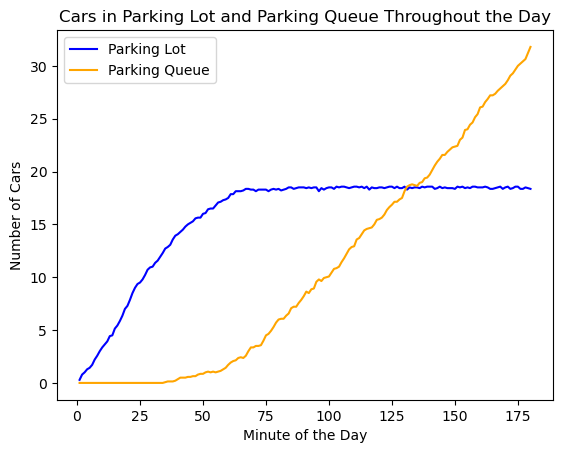

In [57]:
plt.plot(avg_stats(enfield_new)[1]['parking lot'], color = 'blue', label = 'Parking Lot')
plt.plot(avg_stats(enfield_new)[1]['parking queue'], color = 'orange', label = 'Parking Queue')
plt.ylabel('Number of Cars')
plt.xlabel('Minute of the Day')
plt.title('Cars in Parking Lot and Parking Queue Throughout the Day')
plt.legend()

Text(0.5, 1.0, 'Number of People In the Store Throughout the Day')

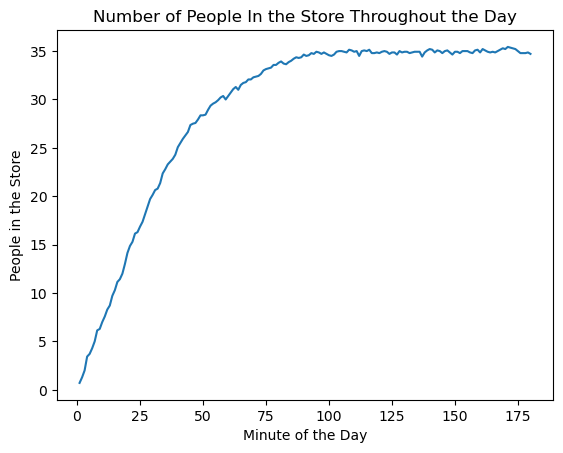

In [77]:
plt.plot(avg_stats_new(enfield_new)[1]['number_of_people'])
plt.ylabel('People in the Store')
plt.xlabel('Minute of the Day')
plt.title('Number of People In the Store Throughout the Day')

In [69]:
cars = 65
per_car = 2
parking_spots = 20
hours_open = 3
names = ["rescued produce", "assorted meats", "baked goods", "clothes", "load car"]
times = [7, 7, 7, 15, 4]
capacities = [3, 3, 3, 7, 1000]
enfield_new = Model(cars, per_car, parking_spots, hours_open, names, times, capacities, ps)

enfield_new.simulate(14)
enfield_new.stats[0][0].head()

,day,enter,leave,total_time,shopping_time,waiting_time
0,1,13,31,18,11,7
1,1,5,32,27,22,5
2,1,9,34,25,19,6
3,1,8,50,42,32,10
4,1,8,50,42,37,5


In [70]:
avg_stats_new(enfield_new)[0]

,days,avg_shoppers_served,avg_shoppers_arrived,avg_people_arrived,avg_cars_arrived,avg_parking_queue,avg_total_time,avg_shopping_time,avg_waiting_time
0,14.0,51.43,88.57,132.43,66.21,7.91,71.24,24.77,46.47


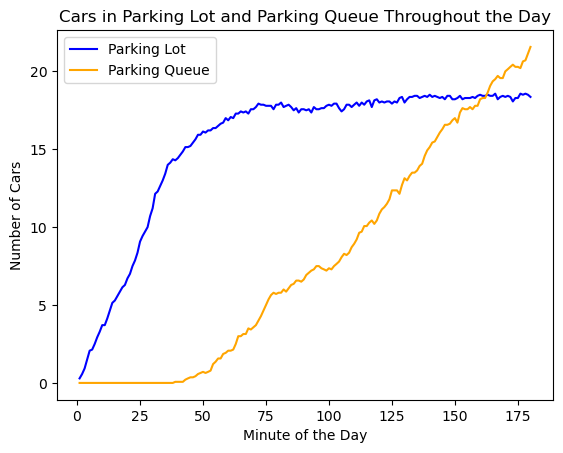

In [71]:
plt.plot(avg_stats(enfield_new)[1]['parking lot'], color = 'blue', label = 'Parking Lot')
plt.plot(avg_stats(enfield_new)[1]['parking queue'], color = 'orange', label = 'Parking Queue')
plt.ylabel('Number of Cars')
plt.xlabel('Minute of the Day')
plt.title('Cars in Parking Lot and Parking Queue Throughout the Day')
plt.legend()

Text(0.5, 1.0, 'Number of People In the Store Throughout the Day')

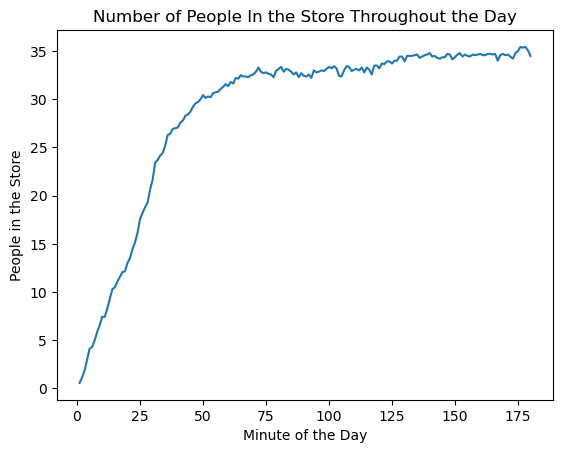

In [72]:
plt.plot(avg_stats_new(enfield_new)[1]['number_of_people'])
plt.ylabel('People in the Store')
plt.xlabel('Minute of the Day')
plt.title('Number of People In the Store Throughout the Day')

As expected, a two fold increase in shopping time does create a bottleneck within the parking lot, thus leading to a parking queue. We can further observe that as we vary times spent in the store we can eventually find an optimal time spent in the store in order to allow as much time as needed for the patrons to shop while preventing a parking lot queue. We see that while the number of car arrival and people arrival are similar for the two different time spent in each section, the parking queue and waiting time is changes quite a bit with varying time spent in each section. This means that being able to decrease the amount of time people spend in each section can have a large impact on waiting times and parking queue. This can be achieved through different designs within the store eg. making more clear signage and displaying products in a way which makes it easier for people to find what they need and decrease shopping time.

### Visualization 4 (Ivan)
This visualization explores the following scenario: We look into how traffic flow and parking queue is affected when the number of people in each car is not set to a constant. Instead, let the number of people in each car arriving to Enfield be modeled through a normal distribution with a mean of 4 people (representing a 4 person family) with a standard deviation of 1 person. Other parameters remain the same as in previous visualizations: cars arrive to the parking lot at a rate determined by a poisson distribution with λ = 0.361, and the shopping times are determined by an exponential distribution with 1/λ = 5 (the expected number of minutes it takes to shop at each station). In a similar way, we also gain insight into the number of people in the system and parking lot state by minute/day.

In [5]:
# Initialize the model with given data from Enfield
cars = 65
parking_spots = 20
hours_open = 3
names = ["rescued produce", "assorted meats", "baked goods", "clothes", "load car"]
times = [5, 5, 5, 10, 4]
capacities = [3, 3, 3, 7, 1000] # capacity for loading car should be infinite since (assume less than 1000 shoppers at a time)
ps = [1, 1, 1, .25, 1]
enfield4 = Model(cars, per_car, parking_spots, hours_open, names, times, capacities, ps)

In [6]:
for i in range(14):
    enfield4.per_car = round(np.random.normal(loc=4,scale=1))
    enfield4.simulate(1)
enfield4.stats[0][0].head()

,day,enter,leave,total_time,shopping_time,waiting_time
0,1,1,23,22,2,20
1,1,1,30,29,25,4
2,1,1,32,31,17,14
3,1,7,35,28,13,15
4,1,1,41,40,35,5


In [7]:
enfield4.stats[0][1]

,day,minute,number_of_people,parking lot,parking queue
0,1,1,5,1,0
1,1,2,5,1,0
2,1,3,5,1,0
3,1,4,5,1,0
4,1,5,5,1,0
...,...,...,...,...,...
175,1,176,100,20,19
176,1,177,100,20,20
177,1,178,100,20,20
178,1,179,100,20,20


In [8]:
def avg_stats4(model):
    avg_people_df = pd.DataFrame(columns = ['days',
                             'avg_shoppers_served',
                             'avg_shoppers_arrived',
                             'avg_people_arrived',
                             'avg_cars_arrived',
                             'avg_parking_queue',
                             'avg_total_time',
                             'avg_shopping_time',
                             'avg_waiting_time'])
    people_dfs = model.stats[0][0]
    for i in model.stats[1:]:
        people_dfs = pd.concat([people_dfs, i[0]])
    stats = np.array(model.arrival_stats)                         
    avg_people_df.loc[0] = [len(model.stats),
                            len(people_dfs.index)/len(model.stats),
                            stats[:, 0].mean(),
                            stats[:, 1].mean(),
                            stats[:, 2].mean(),
                            stats[:, 3].mean(),
                            people_dfs['total_time'].mean(),
                            people_dfs['shopping_time'].mean(),
                            people_dfs['waiting_time'].mean()]
    
    flow_dfs = model.stats[0][1].set_index('minute')
    for i in model.stats[1:]:
        flow_dfs = pd.concat([flow_dfs, i[1]])
    avg_flow_dfs = flow_dfs.groupby('minute').sum()[['number_of_people', 'parking lot', 'parking queue']]/len(model.stats)
    return round(avg_people_df, 2), round(avg_flow_dfs, 2)
avg_stats4(enfield4)[1]

,number_of_people,parking lot,parking queue
minute,,,
1,1.50,0.36,0.00
2,2.50,0.57,0.00
3,3.71,0.86,0.00
4,4.86,1.14,0.00
5,5.43,1.29,0.00
...,...,...,...
176,72.14,18.43,24.43
177,72.43,18.57,24.43
178,71.86,18.36,24.71


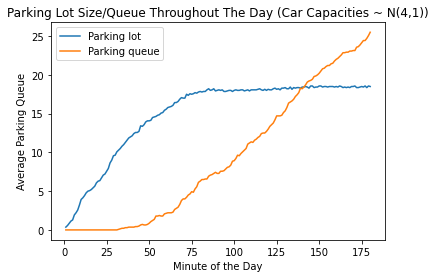

In [9]:
plt.plot(avg_stats4(enfield4)[1]['parking lot'], label = 'Parking lot')
plt.plot(avg_stats4(enfield4)[1]['parking queue'],label = 'Parking queue')
plt.ylabel('Average Parking Queue')
plt.xlabel('Minute of the Day')
plt.title('Parking Lot Size/Queue Throughout The Day (Car Capacities ~ N(4,1))')
plt.legend()

Text(0.5, 1.0, 'Average Number of People Throughout The Day (Car Capacities ~ N(4,1))')

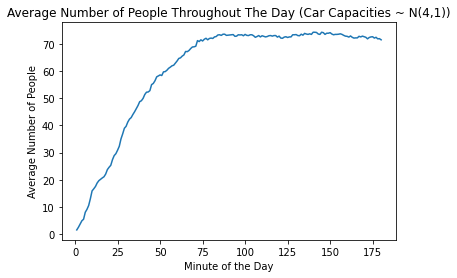

In [10]:
plt.plot(avg_stats4(enfield4)[1]['number_of_people'])
plt.ylabel('Average Number of People')
plt.xlabel('Minute of the Day')
plt.title('Average Number of People Throughout The Day (Car Capacities ~ N(4,1))')

We see that in this case, the parking lot size/queue remains relatively consistent with our previous scenarios because our cars themselves are still arriving through the same Poisson distribution with λ = 0.361. The parking lot is being filled at around minute 90-100 with a parking lot size of 20, and from there, parking lot queue is consistently increasing because the parking lot is full. Something interesting to note is that removing the constant of car capacity = 2 increases a new variable of randomness in our model, therefore increasing the number of minute variations interval by interval in our graphs. Also, we see that this scenario has a higher average number of people in the system because we set the mean capacity of each car to be 4 now, so most of the time (2 standard deviations away --> approximately 97%), the cars arriving will have more than 2 people in them. This causes the pantry to be filled quicker, parking lot to be filled up quicker, and parking queue to increase. Changing a car capacity to take on a mean of 4 with a standard deviation of 1 gives us a more representative model in cases where families are primarily the demographic visiting the pantry and where car capacities are not, for the most part, constant.

### Visualization 5 (Raina)
This visualization is adapted from Visualization 1. This scenario explores the traffic flow when the parking queue is not a factor. This is accounted for by initializing the number of parking spots to be greater than the number of cars that come to the food pantry. Just like Visualization 1, cars arrive to the parking lot at a rate determined by a poisson distribution with λ = 0.361, each car contains two passengers, and the shopping times are determined by an exponential distribution with 1/λ = 5 (the expected number of minutes it takes to shop at each station).

In [7]:
# Initialize the model with given data from Enfield
cars = 65
per_car = 2
parking_spots = 80 # changed from 20 to 80 - Prof. Goldberg mentioned that having a capacity of 20 could be excessive
hours_open = 3
names = ["rescued produce", "assorted meats", "baked goods", "clothes", "load car"]
times = [5, 5, 5, 10, 4]
capacities = [3, 3, 3, 7, 1000] # capacity for loading car should be infinite since (assume less than 1000 shoppers at a time)
ps = [1, 1, 1, .25, 1]
enfield3 = Model(cars, per_car, parking_spots, hours_open, names, times, capacities, ps)

In [8]:
enfield3.simulate(14)
enfield3.stats[0][0].head()


,day,enter,leave,total_time,shopping_time,waiting_time
0,1,2,11,9,5,4
1,1,2,20,18,13,5
2,1,6,27,21,7,14
3,1,3,28,25,12,13
4,1,3,30,27,19,8


In [9]:
enfield3.stats[0][1]

,day,minute,number_of_people,parking lot,parking queue
0,1,1,0,0,0
1,1,2,4,2,0
2,1,3,6,3,0
3,1,4,6,3,0
4,1,5,6,3,0
...,...,...,...,...,...
175,1,176,38,19,0
176,1,177,39,20,0
177,1,178,39,20,0
178,1,179,43,22,0


In [11]:
def avg_stats3(model):
    avg_people_df = pd.DataFrame(columns = ['days',
                             'avg_shoppers_served',
                             'avg_shoppers_arrived',
                             'avg_people_arrived',
                             'avg_cars_arrived',
                             'avg_parking_queue',
                             'avg_total_time',
                             'avg_shopping_time',
                             'avg_waiting_time'])
    people_dfs = model.stats[0][0]
    for i in model.stats[1:]:
        people_dfs = pd.concat([people_dfs, i[0]])
    stats = np.array(model.arrival_stats)                         
    avg_people_df.loc[0] = [len(model.stats),
                            len(people_dfs.index)/len(model.stats),
                            stats[:, 0].mean(),
                            stats[:, 1].mean(),
                            stats[:, 2].mean(),
                            stats[:, 3].mean(),
                            people_dfs['total_time'].mean(),
                            people_dfs['shopping_time'].mean(),
                            people_dfs['waiting_time'].mean()]
    
    flow_dfs = model.stats[0][1].set_index('minute')
    for i in model.stats[1:]:
        flow_dfs = pd.concat([flow_dfs, i[1]])
    avg_flow_dfs = flow_dfs.groupby('minute').sum()[['number_of_people', 'parking lot', 'parking queue']]/len(model.stats)
    return round(avg_people_df, 2), round(avg_flow_dfs, 2)
avg_stats3(enfield3)[0]

,days,avg_shoppers_served,avg_shoppers_arrived,avg_people_arrived,avg_cars_arrived,avg_parking_queue,avg_total_time,avg_shopping_time,avg_waiting_time
0,14.0,70.93,133.0,133.0,66.5,0.0,54.01,18.84,35.16


Text(0.5, 1.0, 'Number of People In the Store Throughout the Day')

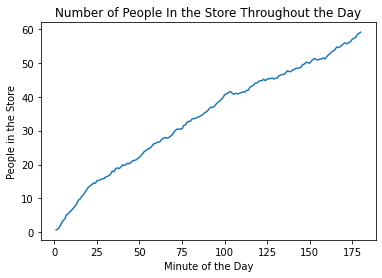

In [12]:
plt.plot(avg_stats3(enfield3)[1]['number_of_people'])
plt.ylabel('People in the Store')
plt.xlabel('Minute of the Day')
plt.title('Number of People In the Store Throughout the Day')

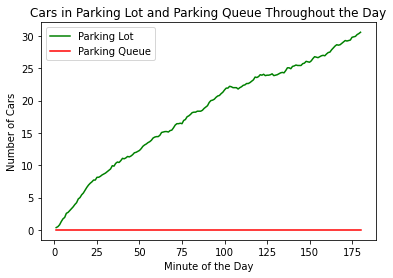

In [14]:
plt.plot(avg_stats3(enfield3)[1]['parking lot'], color = 'green', label = 'Parking Lot')
plt.plot(avg_stats3(enfield3)[1]['parking queue'], color = 'red', label = 'Parking Queue')
plt.ylabel('Number of Cars')
plt.xlabel('Minute of the Day')
plt.title('Cars in Parking Lot and Parking Queue Throughout the Day')
plt.legend()

These visualizations show the average number of people in the food pantry, cars in the parking lot, and in the parking queue at each minute of the day based on aggregated data of 14 days of simulation. From these visualizations, we can see that the maximum number of people in the food pantry at one time is about all 65 people with these parameters, and the number of people grows linearly throughout the day. Similarly, the number of cars in the parking lot grows linearly throughout the day. The parking lot has a capacity of 80 cars, making the queue stay constant at 0. We see this depicted by the red line parallel to the x-axis.